In [1]:
from generate import *
import numpy as np
from UMRtools import *
import matplotlib.pyplot as plt
from PIL import Image
import time
import os.path
import shutil
np.set_printoptions(threshold=np.inf)  #使输出数据完整显示
import warnings
warnings.filterwarnings('ignore')

lum in LMS = [0.45436904 0.47353315 0.0720978 ]
[[1.31265115 0.37916654 0.17658182]
 [0.37916654 0.43588297 0.06613005]
 [0.17658182 0.06613005 1.03101131]]
[[10.82668925 -2.48855249  0.0461736 ]
 [-2.48855249  1.38614356 -0.12768065]
 [ 0.0461736  -0.12768065  1.15767798]]
18.53509145317477
0.012775991216413523
range_deg = 0.034479770809412, buffer_deg = 0.038327973649240565
UMRtools verison: v1.2


## 执行ourmodel的函数

In [2]:
#生成grating
def Generate_Gratings(C,P,SF,D,frameRate,size,stimulus_name):
    '''
    C:contrast,范围在[0,0.5]
    P:#相位,范围[0,2pi)
    SF:spatial frequency,建议范围在10到40之间
    D:方向,范围[0,pi]
    frameRate:帧率（一秒几帧，=1就是静止的,>1就是动的)
    size:图片大小
    stimulus_name:生成文件的文件名
    '''
    mk_path(gratings_path)
    generate_input(gratings_path,C,P,SF,D,frameRate,size,stimulus_name)
    #获取fStimulus及其.cfg文件对应的文件名
    fStimulus=Get_fStimulus_Name(gratings_path,stimulus_name)
    return fStimulus
   

In [3]:
#运行一次代码并记录时间
def Run_Our_Model(frameRate, Simulation_duration,cfg_file_id, *args):
    '''
    可变长参数为：C, P, SF, D, size,stimulus_name
    其中stimulus_name：stimulus的名字（即调用generate.py生成文件时的文件名） 
    如果可变长参数长度为0:固定fStimulus,如果不固定，每次都会生成grating并修改fStimulus,固定的话手动输入固定为哪个
    frameRate=1:静态图片
    Simulation_duration:模拟时长(s)
    log_on:是否打印一些中间值
    cfg_file_id: 指定使用的minimal配置文件编号,默认为空（即使用minimal.cfg作为cfg文件）
    repeat: 每组参数重复实验次数  
     
    '''
    log_on=True
    if len(args) == 0:
        fStimulus='gray1.bin'
    else:
        C, P, SF, D, size, stimulus_name = args
        fStimulus=Generate_Gratings(C,P,SF,D,frameRate,size,stimulus_name)[0]
        fStimulus_path = gratings_path+fStimulus
        shutil.copy(fStimulus_path, RESOURCE_DIR)
    if log_on:
        print(f"fStimulus={RESOURCE_DIR}{fStimulus}")
        file_name = os.path.splitext(fStimulus)[0]
        cfg_file_path = os.path.join(gratings_path, file_name + "_cfg.bin")
        sf, ori, phase, contrast=read_grating_cfg(cfg_file_path)
        print(f"sf={sf},ori={ori},phase={phase},contrast={contrast}")
    
    # 获取使用的配置文件路径
    minimal_cfg_file_path = f"{SRC_DIR}minimal{cfg_file_id}.cfg"
    print(f"minimal_cfg_file_path={minimal_cfg_file_path}")
    if cfg_file_id=='':
        output_suffix = f'merge_test_0'
    else:
        output_suffix = f'merge_test_{cfg_file_id}'
    if log_on:
        print(f"changed minimal_cfg_file = {minimal_cfg_file_path}")  

    #更改cfg文件的值   
    with open(minimal_cfg_file_path, 'r') as file:
    # 读取文件的每一行，并用列表保存
        lines = file.readlines()
        for i in range(len(lines)):
            if "nt =" in lines[i] and "#nt =" not in lines[i] and lines[i][0]=='n':
                lines[i] = f"nt = {int(8000*Simulation_duration)} \n"
                if log_on:
                    print(f"changed nt = {int(8000*Simulation_duration)}") 
            if "fStimulus =" in lines[i] and "#fStimulus =" not in lines[i]:
                lines[i] = f"fStimulus = {fStimulus} \n"
                if log_on:
                    print(f"changed fStimulus = {fStimulus}") 
            if "frameRate =" in lines[i] and "#frameRate =" not in lines[i]:
                lines[i] = f"frameRate = {frameRate} \n"
                if log_on:
                    print(f"changed frameRate = {frameRate}") 
            if "output_suffix =" in lines[i] and "#output_suffix =" not in lines[i]:
                lines[i] = f"output_suffix = {output_suffix} \n"
                if log_on:
                    print(f"changed output_suffix = {output_suffix}")     
        with open(f"{SRC_DIR}/minimal{cfg_file_id}.cfg", 'w') as file:
            # 将修改后的行重新写入到文件中
            file.writelines(lines)

    #记录运行时间
    start_time = time.time()
    os.system(f'cd {PATCHFAST_DIR} && {BIN_DIR}patch_fast -c {SRC_DIR}minimal{cfg_file_id}.cfg > {model_log_path}{now_time_str()}.log')
    
    LGN_spike_time,fr=read_spike(f"{PATCHFAST_DIR}sample_spikeCount-{output_suffix}.bin")
    LGN_spike_time = np.floor(LGN_spike_time).astype(int)
    end_time = time.time()
    total_time = round((end_time - start_time),3)
    
    return LGN_spike_time,fr,total_time
    # LGN_spike_time:[521,8000], fr:[3840,1]
    

## 不同分辨率的图片对计算时间的影响  

In [2]:
#设计实验:不同分辨率的图片对计算时间的影响  
#除了分辨率，其他参数也可以用这个函数类似进行实验，但是刺激时间不能用这个函数，因为刺激时间不同LGN_spike_time的维数不同，不能直接reshape
def Experiment_resolution(mode,repeat=3):
    '''
    以下参数虽然都是固定的(模拟时间1s,frameRate=1)需要的话可以修改
    保存数据的类型都是numpy数组,形状如下
    resolution:(len(resolution),1)
    lgn_spike:(len(resolution),repeat,512,8000)
    v1_fr:(len(resolution),repeat,3840)
    run_time:(len(resolution),repeat)记录运行时间
    '''
    P=np.array([0.5*np.pi])
    SF = np.arange(36,40,10)#36
    D = np.array([np.pi/6])  # 方向范围[0,pi]
    resolution=[16,32,64,80,128,200,256]
    lgn_spike=[]
    v1_fr=[]
    run_time=[]
    if mode=="grey":
        C=np.array([0])
    else:
        C=np.array([0.45])
        
    for index, size in enumerate(resolution):
        for i in range(repeat):
            LGN_spike_time,fr,total_time=Run_Our_Model(1, 1,index+1,C,P,SF,D,size,f'static_color-grid_size{size}')
            lgn_spike.append(LGN_spike_time)
            v1_fr.append(fr)
            run_time.append(total_time)
    
    resolution, lgn_spike, v1_fr, run_time = map(np.array, [resolution, lgn_spike, v1_fr, run_time])
    lgn_spike=lgn_spike.reshape(resolution.shape[0],repeat, 512, -1)
    v1_fr=v1_fr.reshape(resolution.shape[0],repeat, -1)
    run_time=run_time.reshape(resolution.shape[0],repeat, -1)

    if mode=="grey":
        np.savez(img_save_path+'grey.npz',resolution=resolution, lgn_spike=lgn_spike, v1_fr=v1_fr, run_time=run_time)
    
    else:
        np.savez(img_save_path+'static_color-grid_resolution.npz',resolution=resolution, lgn_spike=lgn_spike,v1_fr=v1_fr, run_time=run_time)

    # return resolution, lgn_spike, v1_fr, run_time

def Experiment_Simulation_duration(repeat=3):
    '''
    以下参数虽然都是固定的(模拟时间1s,frameRate=1)需要的话可以修改
    保存数据的类型都是numpy数组,形状如下
    Simulation_durations:(len(Simulation_durations),1)
    lgn_spike_array:大小为(len(Simulation_durations)*repeat,)的数组,每一项是一个(512,nt)的数组
    v1_fr:(len(Simulation_durations),repeat,3840)
    run_time:(len(Simulation_durations),repeat)记录运行时间
    '''
    P=np.array([0.5*np.pi])
    SF = np.arange(36,40,10)#36
    D = np.array([np.pi/6])  # 方向范围[0,pi]
    resolution=128
    # Simulation_durations=[1,2,3,4,5,10,15,20]
    Simulation_durations=[1,2]
    lgn_spike=[]
    v1_fr=[]
    run_time=[]
    C=np.array([0.45])
        
    for index, Simulation_duration in enumerate(Simulation_durations):
        for i in range(repeat):
            LGN_spike_time,fr,total_time=Run_Our_Model(1,Simulation_duration,index+1,C,P,SF,D,resolution,f'static_color-grid_time{Simulation_duration}')
            lgn_spike.append(LGN_spike_time)
            v1_fr.append(fr)
            run_time.append(total_time)
    Simulation_durations, v1_fr, run_time = map(np.array, [Simulation_durations, v1_fr, run_time])   
    v1_fr=v1_fr.reshape(Simulation_durations.shape[0],repeat, -1)
    run_time=run_time.reshape(Simulation_durations.shape[0],repeat, -1)

    lgn_spike_array = np.empty(Simulation_durations.shape[0]*repeat, dtype=object)

    # 逐个将原始列表中的二维数组添加到空数组中
    for i in range(Simulation_durations.shape[0]*repeat):
        lgn_spike_array[i] = lgn_spike[i]

    # 打印结果
    print(lgn_spike_array.shape) 

    np.savez(img_save_path+'Simulation_duration.npz',Simulation_durations=Simulation_durations, lgn_spike_array=lgn_spike_array, v1_fr=v1_fr, run_time=run_time)
    
    # return Simulation_durations, lgn_spike_array, v1_fr, run_time

In [18]:
Experiment_Simulation_duration()

128 degree per pixel
crest in sRGB: [ 1.5214511  -1.83242368  0.72781358]
valley in sRGB: [-18.30753009   1.0386155    0.67997673]
0.0011376210071664464 degree per pixel
ecc = 0.034479770809412, buffer_ecc = 0.038327973649240565
1
adjusted to 1 frames in total
sharpness=1.0
it: 0
sRGB space is not enough to represent the color
(array([-18.30752992,  -1.83242248,   0.67997673]), array([1.52145102, 1.0386155 , 0.72781358]))
fStimulus=/home/zhaobenyan/model/resource/static_color-grid_time1.bin
sf=36.0,ori=30.0,phase=90.0,contrast=0.44999998807907104
minimal_cfg_file_path=/home/zhaobenyan/model/repos/patchV1/src/minimal1.cfg
changed minimal_cfg_file = /home/zhaobenyan/model/repos/patchV1/src/minimal1.cfg
changed output_suffix = merge_test_1
changed fStimulus = static_color-grid_time1.bin
changed frameRate = 1
changed nt = 8000
128 degree per pixel
crest in sRGB: [ 1.5214511  -1.83242368  0.72781358]
valley in sRGB: [-18.30753009   1.0386155    0.67997673]
0.0011376210071664464 degree per p

In [51]:
resolution,lgn,v1,run_time=Experiment_resolution(mode="grating",repeat=10)

16 degree per pixel
crest in sRGB: [ 1.5214511  -1.83242368  0.72781358]
valley in sRGB: [-18.30753009   1.0386155    0.67997673]
0.009100968057331571 degree per pixel
ecc = 0.034479770809412, buffer_ecc = 0.038327973649240565
1
adjusted to 1 frames in total
sharpness=1.0
it: 0
sRGB space is not enough to represent the color
(array([-18.28771929,  -1.83163078,   0.67999573]), array([1.52140069, 1.03841998, 0.7278113 ]))
fStimulus=/home/zhaobenyan/model/resource/static_color-grid_size16.bin
sf=36.0,ori=30.0,phase=90.0,contrast=0.44999998807907104
minimal_cfg_file_path=/home/zhaobenyan/model/repos/patchV1/src/minimal1.cfg
changed minimal_cfg_file = /home/zhaobenyan/model/repos/patchV1/src/minimal1.cfg
changed output_suffix = merge_test_1
changed fStimulus = static_color-grid_size16.bin
changed frameRate = 1
changed nt = 8000
16 degree per pixel
crest in sRGB: [ 1.5214511  -1.83242368  0.72781358]
valley in sRGB: [-18.30753009   1.0386155    0.67997673]
0.009100968057331571 degree per pix

In [3]:
#计算lgn_fr,可以去掉指定时间之前的数据
def compute_lgn_fr(cut_off_time,mode,parameter):
  '''
  parameter=="Simulation_durations":说明Simulation_durations是变量，需要单独处理lgn_spike
  cut_off_time:截断时间，即不考虑该时间之前是spike,单位ms
  lgn_fr:(len(resolution), repeat, 512)  eg:(2,3,512)
  v1_fr:(len(resolution), repeat, 3840)
  '''
  dt=0.125
  
  if parameter=="Simulation_duration":
    with np.load(img_save_path+'Simulation_duration.npz',allow_pickle=True) as data:
      Simulation_durations = data['Simulation_durations']
      lgn_spike_array = data['lgn_spike_array']
      v1_fr = data['v1_fr']
      run_time = data['run_time']
      lgn_fr_list=[]
      # print(lgn_spike_array.shape[0])
      for i in range(lgn_spike_array.shape[0]):
        lgn_spike_single=lgn_spike_array[i]
        time_ms=lgn_spike_single.shape[1]*dt  #模拟时长(ms)
        cut=cut_off_time/dt #(cut_off_time/(nt*dt))*nt  
        #截断的模拟次数，例如模拟时长1s时模拟8000次，cut_off_time设置为200ms,那么只计算后6400次的spike
        lgn_fr_single=np.sum(lgn_spike_single[:,int(cut):],axis=1)/((time_ms-cut_off_time)/1000) #(2, 3, 512, nt)->(2,3,512)
        print(f"lgn_fr={lgn_fr_single.shape}")
        lgn_fr_list.append(lgn_fr_list)
      lgn_fr=np.array(lgn_fr_list).reshape(Simulation_durations.shape[0],len(lgn_fr_list)/Simulation_durations.shape[0], -1)
    print(lgn_fr.shape)
        
      
  # else:
  #   if mode=="grey":
  #     with np.load(img_save_path+'grey.npz') as data:
  #       resolution = data['resolution']
  #       lgn_spike = data['lgn_spike']
  #       v1_fr = data['v1_fr']
  #       run_time = data['run_time']
  #   else:
  #     with np.load(img_save_path+'static_color-grid_resolution.npz') as data:
  #       resolution = data['resolution']
  #       lgn_spike = data['lgn_spike']
  #       v1_fr = data['v1_fr']
  #       run_time = data['run_time']

  #   time_ms=lgn_spike.shape[3]*dt  #模拟时长(ms)
  #   cut=cut_off_time/dt #(cut_off_time/(nt*dt))*nt  
  #   #截断的模拟次数，例如模拟时长1s时模拟8000次，cut_off_time设置为200ms,那么只计算后6400次的spike
  #   lgn_fr=np.sum(lgn_spike[:,:,:,int(cut):],axis=3)/((time_ms-cut_off_time)/1000) #(2, 3, 512, nt)->(2,3,512)
  #   print(f"lgn_fr={lgn_fr.shape}")

  # lgn_fr_max=np.max(np.mean(lgn_fr,axis=1),axis=1)#(2, 3, 512)->(2,512)->(2,)
  # v1_fr_max=np.max(np.mean(v1_fr,axis=1),axis=1)
  # lgn_fr_mean=np.mean(np.mean(lgn_fr,axis=1),axis=1)
  # v1_fr_mean=np.mean(np.mean(v1_fr,axis=1),axis=1)
  # run_time_mean=np.mean(np.mean(run_time,axis=1),axis=1)

  # return resolution,lgn_fr_max, v1_fr_max, lgn_fr_mean, v1_fr_mean,run_time_mean
  

In [4]:
compute_lgn_fr(0,1,"Simulation_duration")

lgn_fr=(512,)
lgn_fr=(512,)
lgn_fr=(512,)
lgn_fr=(512,)
lgn_fr=(512,)
lgn_fr=(512,)


KeyboardInterrupt: 

In [49]:
def plot(resolution,lgn_fr_max,v1_fr_max,lgn_fr_mean,v1_fr_mean,run_time_mean):
  # 为了方便，我们将所有向量转换为一维数组
  resolution = resolution.flatten()
  lgn_fr_vector = lgn_fr_mean.flatten()
  v1_fr_vector = v1_fr_mean.flatten()
  # lgn_max_vector = lgn_fr_max.flatten()
  v1_max_vector = v1_fr_max.flatten()
  run_time_vector = run_time_mean.flatten()

  #颜色
  # color=['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','#BEB8DC','#E7DAD2']
  color=['#2878b5','#c82423','#ff8884','#9ac9db','#f8ac8c',]

  # 创建一个新的图形
  fig, ax = plt.subplots(figsize=(6, 5))
  plt.xticks(resolution)

  # 创建第一个纵坐标
  ax.set_xlabel('resolution')
  ax.set_ylabel('lgn_fr(Hz)', fontsize=14, labelpad=10,color=color[0]).set_rotation(0)
  ax.plot(resolution, lgn_fr_vector, color=color[0], marker='o')
  ax.tick_params(axis='y', labelcolor=color[0])
  ax.set_ylim([0, np.max(lgn_fr_vector)*1.2])

  # 创建第二个纵坐标
  ax2 = ax.twinx()
  ax2.set_ylabel('v1_fr(Hz)', fontsize=14, labelpad=30,color=color[1]).set_rotation(0)
  ax2.plot(resolution, v1_fr_vector, color=color[1], marker='o')
  ax2.tick_params(axis='y', labelcolor=color[1])
  ax2.set_ylim([0, np.max(v1_fr_vector)*1.2])

  # 创建第三个纵坐标
  ax3 = ax.twinx()
  ax3.spines.right.set_position(('axes', 1.2))
  ax3.set_ylabel('run_time(s)', fontsize=14, labelpad=40,color=color[2]).set_rotation(0)
  ax3.plot(resolution, run_time_vector, color=color[2], marker='o')
  ax3.tick_params(axis='y', labelcolor=color[2])
  ax3.set_ylim([0, np.max(run_time_vector)*1.1])

  # 创建第四个纵坐标
  ax4 = ax.twinx()
  ax4.spines.right.set_position(('axes', 1.4))
  ax4.set_ylabel('v1_std(Hz)', fontsize=14, labelpad=40,color=color[3]).set_rotation(0)
  ax4.plot(resolution, v1_max_vector, color=color[3], marker='o')
  ax4.tick_params(axis='y', labelcolor=color[3])
  ax4.set_ylim([0, np.max(v1_max_vector)*1.3])
  # ax5.tick_params(labelright=False)

  # 显示每个点的值
  for i in range(len(resolution)):

      ax.annotate(f"{lgn_fr_vector[i]:.2f}", (resolution[i], lgn_fr_vector[i]), xytext=(resolution[i]-6, lgn_fr_vector[i]*1.03),color=color[0])

      ax3.annotate(f"{run_time_vector[i]:.2f}", (resolution[i], run_time_vector[i]), xytext=(resolution[i], run_time_vector[i]*1.02),color=color[2])

      if i==0:
          ax2.annotate(f"{v1_fr_vector[i]:.2f}", (resolution[i], v1_fr_vector[i]), xytext=(resolution[i]+3, v1_fr_vector[i]*0.95),color=color[1])
          ax4.annotate(f"{v1_max_vector[i]:.4f}", (resolution[i], v1_max_vector[i]), xytext=(resolution[i]-8, v1_max_vector[i]*0.8),color=color[3])
      else:
          ax2.annotate(f"{v1_fr_vector[i]:.2f}", (resolution[i], v1_fr_vector[i]), xytext=(resolution[i], v1_fr_vector[i]*0.95),color=color[1])
          ax4.annotate(f"{v1_max_vector[i]:.4f}", (resolution[i], v1_max_vector[i]), xytext=(resolution[i]-8, v1_max_vector[i]*0.92),color=color[3])

  # 显示图例
  legend_labels = ['lgn_fr(Hz)', 'v1_fr(Hz)', 'run_time(s)','v1_std(Hz)']
  plt.legend([ax.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0],ax4.get_lines()[0]], legend_labels, loc='center', bbox_to_anchor=(0.5, 0.1))

  # 显示图形
  plt.show()

resolution=[ 16  32  64  80 128 200 256]
lgn_spike_shape=(7, 10, 512, 8000)
v1_fr=(7, 10, 3840)
(7, 10, 1)
lgn_fr=[[[ 90.   0. 160.   0. 339.   0. 359. 221.   0. 369.   0.   0. 247.   0.
     0.   0.   0. 251. 320. 348.   0.   0. 403.   0.   0. 387. 229.  47.
   243.   0.   0. 355.   0. 150.  85. 197.   0.   0. 393. 168.   0.   0.
     0.   0. 326. 314.   0.   0.   0.   0.   0.   0. 282.   0.   0.  35.
     0. 390.   0.   0. 192.   0.   0.   0.   6.   0.   0.   0.   0.   0.
     0. 304. 206. 358. 374.   0. 320. 334. 254.  18. 212. 171. 351.  87.
     0.   0.   0.   0. 236.   0.   0. 409. 183.   0.   0.  73.   0.   0.
     0.   0.   0.   0. 116. 355.   0.   0.   0. 133.   0.   0. 347.  71.
     0.   0.   0.   0.   0.   0.   0. 152.   0. 412.  72. 236. 296. 349.
   389.   0.   0. 239.   0. 361.   0. 194.   0.   0. 381.   0. 384. 182.
     0. 284. 183. 172. 385.   0.   0.   0. 306. 122.   0. 372. 114.   0.
     0.   0.   0. 200. 395.   0. 342.   0.   0.   0. 373. 233.   0.   0.
   319. 31

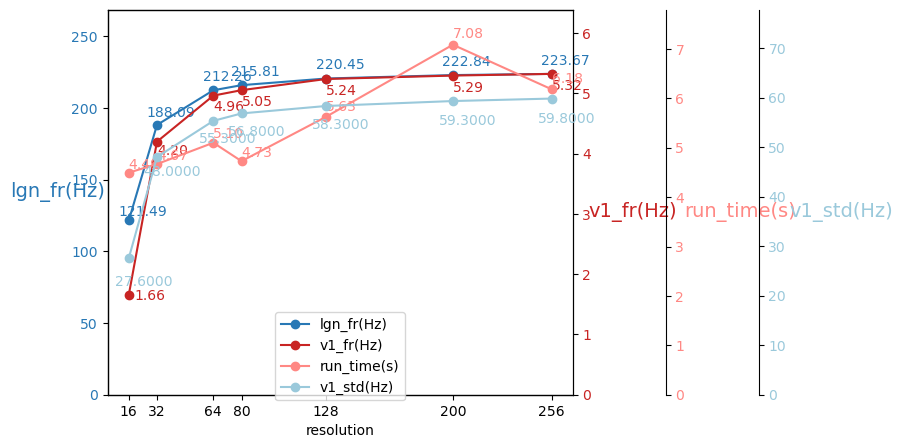

In [52]:
resolution,lgn_fr_max, v1_fr_max, lgn_fr_mean, v1_fr_mean,run_time_mean=compute_lgn_fr(0,mode="grating")
plot(resolution,lgn_fr_max, v1_fr_max, lgn_fr_mean, v1_fr_mean,run_time_mean)

## fr和运行时间随刺激时长的变化

In [4]:
#运行之后会保存一个文件，之后直接读取即可
C=np.array([0.45])
P=np.array([0.5*np.pi])
SF = np.arange(36,40,10)#36
D = np.array([np.pi/6])  # 方向范围[0,pi]
frameRate=1
size=128
Simulation_durations=[1,2,3,4,5,10,15,20]
repeat=10
lgn_mean_fr=[]
v1_mean_fr=[]
run_time=[]
for Simulation_duration in Simulation_durations:
    for i in range(repeat):
        lgn_mean_fr0,v1_mean_fr0,total_time=Run_Our_Model(C,P,SF,D,frameRate,size,Simulation_duration,fixd=True)
        lgn_mean_fr.append(lgn_mean_fr0)
        v1_mean_fr.append(v1_mean_fr0)
        run_time.append(total_time)
with open('Simulation_duration_128.bin', 'wb') as f:
    np.save(f,np.array(Simulation_durations))
    np.save(f, lgn_mean_fr) #(8,10)
    np.save(f, v1_mean_fr)
    np.save(f, run_time)
# np.savez('Simulation_duration_{}.npz'.format(size), Simulation_durations=Simulation_durations, lgn_mean_fr=lgn_mean_fr, v1_mean_fr=v1_mean_fr, run_time=run_time)

fStimulus=/home/zhaobenyan/model/resource/static_color-grid_size_128.bin
sf=36.0,ori=30.0,phase=90.0,contrast=0.44999998807907104
changed fStimulus = static_color-grid_size_128.bin
changed frameRate = 1
changed nt = 8000
pixel为 128 时运行时间为 9.08 秒
(512, 8000) (3840,)
fStimulus=/home/zhaobenyan/model/resource/static_color-grid_size_128.bin
sf=36.0,ori=30.0,phase=90.0,contrast=0.44999998807907104
changed fStimulus = static_color-grid_size_128.bin
changed frameRate = 1
changed nt = 8000
pixel为 128 时运行时间为 6.92 秒
(512, 8000) (3840,)
fStimulus=/home/zhaobenyan/model/resource/static_color-grid_size_128.bin
sf=36.0,ori=30.0,phase=90.0,contrast=0.44999998807907104
changed fStimulus = static_color-grid_size_128.bin
changed frameRate = 1
changed nt = 8000
pixel为 128 时运行时间为 6.88 秒
(512, 8000) (3840,)
fStimulus=/home/zhaobenyan/model/resource/static_color-grid_size_128.bin
sf=36.0,ori=30.0,phase=90.0,contrast=0.44999998807907104
changed fStimulus = static_color-grid_size_128.bin
changed frameRate = 1

In [6]:
# 从二进制文件中加载数组
with open('Simulation_duration_time.bin', 'rb') as f:
    Simulation_duration = np.load(f)  
    #这里上次运行存数据的时候少加了个s（已修改）导致是空集，所以后面手动定义了一遍Simulation_duration
    lgn_fr = np.load(f)
    v1_fr = np.load(f)
    run_time = np.load(f)
Simulation_duration=np.array([1,2,3,4,5,10,15,20])
repeat=10
lgn_fr_mean = np.mean(np.array(lgn_fr).reshape(len(Simulation_duration),repeat, -1),axis=1) #(8,10)-->(8,)
v1_fr_mean = np.mean(np.array(v1_fr).reshape(len(Simulation_duration),repeat, -1),axis=1)
lgn_fr_std = np.std(np.array(lgn_fr).reshape(len(Simulation_duration),repeat, -1),axis=1)
v1_fr_std = np.std(np.array(v1_fr).reshape(len(Simulation_duration),repeat, -1),axis=1)
run_time_mean = np.mean(np.array(run_time).reshape(len(Simulation_duration),repeat, -1),axis=1)
print(Simulation_duration.shape)
print(lgn_fr_std)
print(v1_fr_std)

(8,)
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.84217094e-14]
 [0.00000000e+00]
 [0.00000000e+00]]
[[0.00462348]
 [0.00327535]
 [0.00241351]
 [0.00298063]
 [0.00222659]
 [0.00112897]
 [0.00121998]
 [0.00080084]]


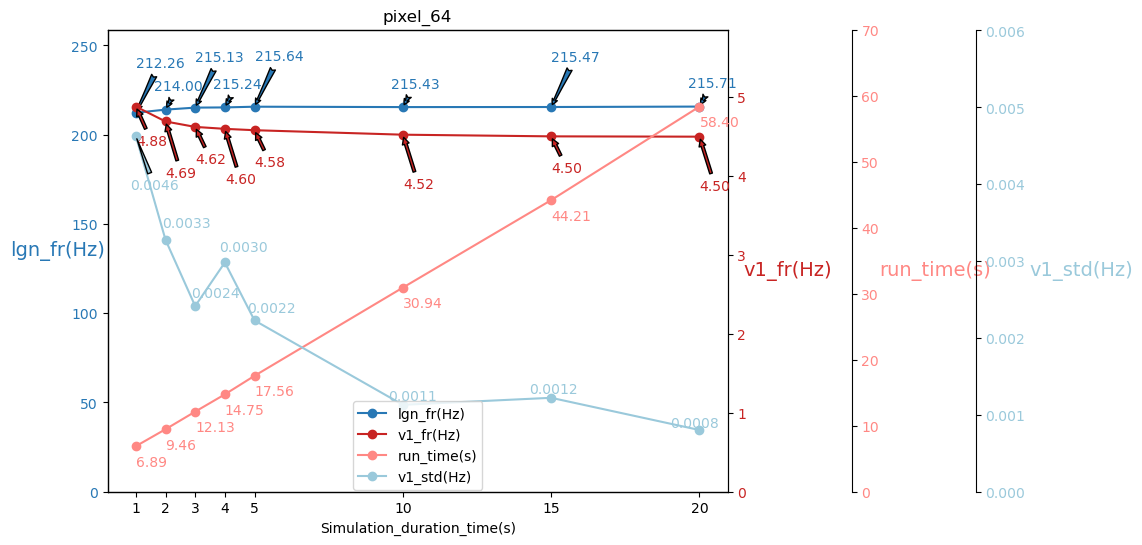

In [7]:
# 为了方便，我们将所有向量转换为一维数组
Simulation_duration = Simulation_duration.flatten()
lgn_fr_vector = lgn_fr_mean.flatten()
v1_fr_vector = v1_fr_mean.flatten()
lgn_std_vector = lgn_fr_std.flatten()
v1_std_vector = v1_fr_std.flatten()
run_time_vector = run_time_mean.flatten()

#颜色
# color=['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','#BEB8DC','#E7DAD2']
color=['#2878b5','#c82423','#ff8884','#9ac9db','#f8ac8c',]

# 创建一个新的图形
fig, ax = plt.subplots(figsize=(8, 6))
plt.xticks(Simulation_duration)

# 创建第一个纵坐标
ax.set_xlabel('Simulation_duration_time(s)')
ax.set_ylabel('lgn_fr(Hz)', fontsize=14, labelpad=10,color=color[0]).set_rotation(0)
ax.plot(Simulation_duration, lgn_fr_vector, color=color[0], marker='o')
ax.tick_params(axis='y', labelcolor=color[0])
ax.set_ylim([0, np.max(lgn_fr_vector)*1.2])

# 创建第二个纵坐标
ax2 = ax.twinx()
ax2.set_ylabel('v1_fr(Hz)', fontsize=14, labelpad=30,color=color[1]).set_rotation(0)
ax2.plot(Simulation_duration, v1_fr_vector, color=color[1], marker='o')
ax2.tick_params(axis='y', labelcolor=color[1])
ax2.set_ylim([0, np.max(v1_fr_vector)*1.2])

# 创建第三个纵坐标
ax3 = ax.twinx()
ax3.spines.right.set_position(('axes', 1.2))
ax3.set_ylabel('run_time(s)', fontsize=14, labelpad=40,color=color[2]).set_rotation(0)
ax3.plot(Simulation_duration, run_time_vector, color=color[2], marker='o')
ax3.tick_params(axis='y', labelcolor=color[2])
ax3.set_ylim([0, np.max(run_time_vector)*1.2])

# # 创建第四个纵坐标  lgn_std全为0，不再展示
# ax4 = ax.twinx()
# ax4.spines.right.set_position(('axes', 1.2))
# ax4.set_ylabel('lgn_std/Hz', fontsize=14, labelpad=40,color='yellow').set_rotation(0)
# ax4.plot(sizes, lgn_std_vector, color='yellow', marker='o')
# ax4.tick_params(axis='y', labelcolor='yellow')
# ax4.set_ylim([0, np.max(lgn_std_vector)+0.1])
# # ax4.tick_params(labelright=False)  #隐藏纵坐标轴

# 创建第五个纵坐标
ax4 = ax.twinx()
ax4.spines.right.set_position(('axes', 1.4))
ax4.set_ylabel('v1_std(Hz)', fontsize=14, labelpad=40,color=color[3]).set_rotation(0)
ax4.plot(Simulation_duration, v1_std_vector, color=color[3], marker='o')
ax4.tick_params(axis='y', labelcolor=color[3])
ax4.set_ylim([0, np.max(v1_std_vector)*1.3])
# ax5.tick_params(labelright=False)

# 显示每个点的值，为了展示出来好看需要挨个儿调文字位置、箭头形状位置颜色等。
for i in range(len(Simulation_duration)):

    if i % 2 == 0:
        ax.annotate(f"{lgn_fr_vector[i]:.2f}", (Simulation_duration[i], lgn_fr_vector[i]), xytext=(Simulation_duration[i], lgn_fr_vector[i]*1.12),arrowprops=dict(facecolor=color[0], arrowstyle='fancy'),color=color[0])
        ax2.annotate(f"{v1_fr_vector[i]:.2f}", (Simulation_duration[i], v1_fr_vector[i]), xytext=(Simulation_duration[i], v1_fr_vector[i]*0.9),arrowprops=dict(facecolor=color[1], arrowstyle='simple'),color=color[1])
    else:
        ax.annotate(f"{lgn_fr_vector[i]:.2f}", (Simulation_duration[i], lgn_fr_vector[i]), xytext=(Simulation_duration[i]-0.4, lgn_fr_vector[i]*1.05),arrowprops=dict(facecolor=color[0], arrowstyle='fancy'),color=color[0])
        ax2.annotate(f"{v1_fr_vector[i]:.2f}", (Simulation_duration[i], v1_fr_vector[i]), xytext=(Simulation_duration[i], v1_fr_vector[i]*0.85),arrowprops=dict(facecolor=color[1], arrowstyle='simple'),color=color[1])

    ax3.annotate(f"{run_time_vector[i]:.2f}", (Simulation_duration[i], run_time_vector[i]), xytext=(Simulation_duration[i], run_time_vector[i]-3),color=color[2])

    # ax4.annotate(f"{lgn_std_vector[i]:.2f}", (sizes[i], lgn_std_vector[i]), xytext=(sizes[i], lgn_std_vector[i]),color='yellow')
    if i==0:
        ax4.annotate(f"{v1_std_vector[i]:.4f}", (Simulation_duration[i], v1_std_vector[i]), xytext=(Simulation_duration[i]*0.8, v1_std_vector[i]*0.85),arrowprops=dict(facecolor=color[3], arrowstyle='wedge'),color=color[3])
    else:
        ax4.annotate(f"{v1_std_vector[i]:.4f}", (Simulation_duration[i], v1_std_vector[i]), xytext=(Simulation_duration[i]*0.95, v1_std_vector[i]*1.05),color=color[3])

# 显示图例
legend_labels = ['lgn_fr(Hz)', 'v1_fr(Hz)', 'run_time(s)','v1_std(Hz)']
plt.legend([ax.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0],ax4.get_lines()[0]], legend_labels, loc='center', bbox_to_anchor=(0.5, 0.1))
plt.title('pixel_64')

# 显示图形
plt.show()

## fr和运行时间随pixel大小的变化

In [ ]:
#fr和运行时间随刺激时长的变化
C=np.array([0.45])
P=np.array([0.5*np.pi])
SF = np.arange(36,40,10)#36
D = np.array([np.pi/6])  # 方向范围[0,pi]
frameRate=1
resolution=[16,32,64,80,128,200,256]
repeat=10
lgn_mean_fr=[]
v1_mean_fr=[]
run_time=[]
for size in resolution:
    for i in range(repeat):
        lgn_mean_fr0,v1_mean_fr0,total_time=Run_Our_Model(C,P,SF,D,frameRate,size,Simulation_duration=1,fixd=False)
        np.savez(img_save_path+'gray.npz', LGN_spike_time=LGN_spike_time, fr=fr, total_time=total_time)
        lgn_mean_fr.append(lgn_mean_fr0)
        v1_mean_fr.append(v1_mean_fr0)
        run_time.append(total_time)
with open('pixel_time.bin', 'wb') as f:
    np.save(f,np.array(resolution))
    np.save(f, lgn_mean_fr)  #(8,10)
    np.save(f, v1_mean_fr)
    np.save(f, run_time)

In [8]:
# 从二进制文件中加载数组
with open('pixel_time.bin', 'rb') as f:
    resolution = np.load(f)
    lgn_fr = np.load(f)
    v1_fr = np.load(f)
    run_time = np.load(f)
repeat=10
lgn_fr_mean = np.mean(np.array(lgn_fr).reshape(len(resolution),repeat, -1),axis=1) #(8,10)-->(8,)
v1_fr_mean = np.mean(np.array(v1_fr).reshape(len(resolution),repeat, -1),axis=1)
lgn_fr_std = np.std(np.array(lgn_fr).reshape(len(resolution),repeat, -1),axis=1)
v1_fr_std = np.std(np.array(v1_fr).reshape(len(resolution),repeat, -1),axis=1)
run_time_mean = np.mean(np.array(run_time).reshape(len(resolution),repeat, -1),axis=1)
print(resolution.shape)
print(lgn_fr_std)
print(v1_fr_std)

(7,)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.00204456]
 [0.0041804 ]
 [0.00555665]
 [0.00594275]
 [0.00418947]
 [0.00739643]
 [0.0052579 ]]


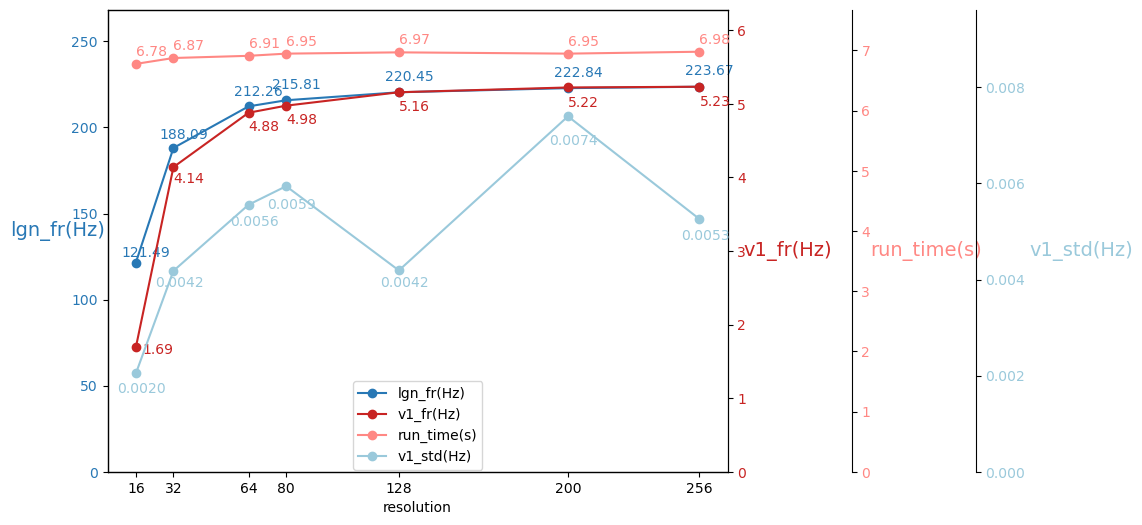

In [10]:
import matplotlib.pyplot as plt

# 为了方便，我们将所有向量转换为一维数组
resolution = resolution.flatten()
lgn_fr_vector = lgn_fr_mean.flatten()
v1_fr_vector = v1_fr_mean.flatten()
lgn_std_vector = lgn_fr_std.flatten()
v1_std_vector = v1_fr_std.flatten()
run_time_vector = run_time_mean.flatten()

#颜色
# color=['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','#BEB8DC','#E7DAD2']
color=['#2878b5','#c82423','#ff8884','#9ac9db','#f8ac8c',]

# 创建一个新的图形
fig, ax = plt.subplots(figsize=(8, 6))
plt.xticks(resolution)

# 创建第一个纵坐标
ax.set_xlabel('resolution')
ax.set_ylabel('lgn_fr(Hz)', fontsize=14, labelpad=10,color=color[0]).set_rotation(0)
ax.plot(resolution, lgn_fr_vector, color=color[0], marker='o')
ax.tick_params(axis='y', labelcolor=color[0])
ax.set_ylim([0, np.max(lgn_fr_vector)*1.2])

# 创建第二个纵坐标
ax2 = ax.twinx()
ax2.set_ylabel('v1_fr(Hz)', fontsize=14, labelpad=30,color=color[1]).set_rotation(0)
ax2.plot(resolution, v1_fr_vector, color=color[1], marker='o')
ax2.tick_params(axis='y', labelcolor=color[1])
ax2.set_ylim([0, np.max(v1_fr_vector)*1.2])

# 创建第三个纵坐标
ax3 = ax.twinx()
ax3.spines.right.set_position(('axes', 1.2))
ax3.set_ylabel('run_time(s)', fontsize=14, labelpad=40,color=color[2]).set_rotation(0)
ax3.plot(resolution, run_time_vector, color=color[2], marker='o')
ax3.tick_params(axis='y', labelcolor=color[2])
ax3.set_ylim([0, np.max(run_time_vector)*1.1])

# # 创建第四个纵坐标
# ax4 = ax.twinx()
# ax4.spines.right.set_position(('axes', 1.2))
# ax4.set_ylabel('lgn_std/Hz', fontsize=14, labelpad=40,color='yellow').set_rotation(0)
# ax4.plot(sizes, lgn_std_vector, color='yellow', marker='o')
# ax4.tick_params(axis='y', labelcolor='yellow')
# ax4.set_ylim([0, np.max(lgn_std_vector)+0.1])
# # ax4.tick_params(labelright=False)  #隐藏纵坐标轴

# 创建第五个纵坐标
ax4 = ax.twinx()
ax4.spines.right.set_position(('axes', 1.4))
ax4.set_ylabel('v1_std(Hz)', fontsize=14, labelpad=40,color=color[3]).set_rotation(0)
ax4.plot(resolution, v1_std_vector, color=color[3], marker='o')
ax4.tick_params(axis='y', labelcolor=color[3])
ax4.set_ylim([0, np.max(v1_std_vector)*1.3])
# ax5.tick_params(labelright=False)

# 显示每个点的值
for i in range(len(resolution)):

    ax.annotate(f"{lgn_fr_vector[i]:.2f}", (resolution[i], lgn_fr_vector[i]), xytext=(resolution[i]-6, lgn_fr_vector[i]*1.03),color=color[0])

    ax3.annotate(f"{run_time_vector[i]:.2f}", (resolution[i], run_time_vector[i]), xytext=(resolution[i], run_time_vector[i]*1.02),color=color[2])

    # ax4.annotate(f"{lgn_std_vector[i]:.2f}", (sizes[i], lgn_std_vector[i]), xytext=(sizes[i], lgn_std_vector[i]),color='yellow')
    if i==0:
        ax2.annotate(f"{v1_fr_vector[i]:.2f}", (resolution[i], v1_fr_vector[i]), xytext=(resolution[i]+3, v1_fr_vector[i]*0.95),color=color[1])
        ax4.annotate(f"{v1_std_vector[i]:.4f}", (resolution[i], v1_std_vector[i]), xytext=(resolution[i]-8, v1_std_vector[i]*0.8),color=color[3])
    else:
        ax2.annotate(f"{v1_fr_vector[i]:.2f}", (resolution[i], v1_fr_vector[i]), xytext=(resolution[i], v1_fr_vector[i]*0.95),color=color[1])
        ax4.annotate(f"{v1_std_vector[i]:.4f}", (resolution[i], v1_std_vector[i]), xytext=(resolution[i]-8, v1_std_vector[i]*0.92),color=color[3])

# 显示图例
legend_labels = ['lgn_fr(Hz)', 'v1_fr(Hz)', 'run_time(s)','v1_std(Hz)']
plt.legend([ax.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0],ax4.get_lines()[0]], legend_labels, loc='center', bbox_to_anchor=(0.5, 0.1))

# 显示图形
plt.show()

## 工具函数

In [7]:
#将实验用的grating拼成一张图用于展示

# 设置每个小图片的宽高
width, height = 256, 256

# 创建一张新的大图片
result = Image.new('RGB', (width * 4, height*2))

# 循环遍历每张小图片，并将其粘贴到大图片上
for i, size in enumerate([16,32,64,80,128,200,256]):
    # 打开当前小图片
    img = Image.open(f'/home/zhaobenyan/model/data_save/gratings/static_color-grid_size_{size}.png')
    # 缩放小图片到指定大小
    img = img.resize((width, height))
    # 计算当前小图片应该被粘贴到大图片的哪个位置
    x = (i % 4) * width
    y = (i // 4) * height
    # 将当前小图片粘贴到大图片上
    result.paste(img, (x, y))

# 保存结果图片
result.save('/home/zhaobenyan/model/data_save/gratings/static_color-grid_combined.png')

In [13]:
# 显示文件的创建时间
filename = "/home/zhaobenyan/model/merge_test/plotLGN_response_merge_test.py" #文件名
if os.path.exists(filename):
    # 获取文件最后修改时间
    last_modified_time = os.path.getmtime(filename)
    # 将时间戳转换为本地时间
    local_time = time.localtime(last_modified_time)
    # 格式化时间输出
    print(f"The image was last modified on {time.strftime('%Y-%m-%d %H:%M:%S', local_time)}.")
else:
    print("The image file does not exist.")

The image was last modified on 2023-03-16 08:10:57.


/tmp/ipykernel_1347187/862221655.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


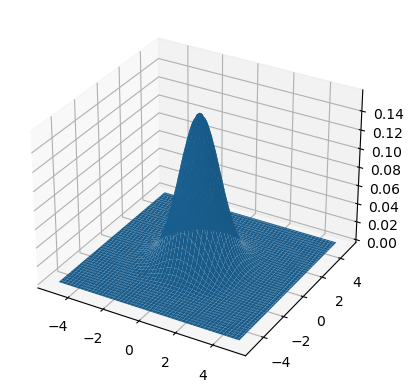

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def gaussian(x, y, sigma):
    return 1/(2*np.pi*sigma**2)*np.exp(-(x**2+y**2)/(2*sigma**2))

# Create a grid of x and y values
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the Gaussian function at each point in the grid
sigma = 1
Z = gaussian(X, Y, sigma)

# Plot the function as a surface plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()


/tmp/ipykernel_1347187/1600011365.py:21: RuntimeWarning: divide by zero encountered in log
  A1 = (temp.nR-1) * np.log(tau1)
/tmp/ipykernel_1347187/1600011365.py:22: RuntimeWarning: divide by zero encountered in log
  A2 = (temp.nD-1) * np.log(tau2)
/tmp/ipykernel_1347187/1600011365.py:25: RuntimeWarning: invalid value encountered in subtract
  tp = tpR - temp.ratio * tpD
/tmp/ipykernel_1347187/1600011365.py:32: RuntimeWarning: divide by zero encountered in log
  A1 = (nR-1) * np.log(tau1)
/tmp/ipykernel_1347187/1600011365.py:33: RuntimeWarning: divide by zero encountered in log
  A2 = (nD-1) * np.log(tau2)
/tmp/ipykernel_1347187/1600011365.py:36: RuntimeWarning: invalid value encountered in subtract
  tp = tpR - ratio * tpD
/tmp/ipykernel_1347187/1600011365.py:32: RuntimeWarning: invalid value encountered in log
  A1 = (nR-1) * np.log(tau1)
/tmp/ipykernel_1347187/1600011365.py:33: RuntimeWarning: invalid value encountered in log
  A2 = (nD-1) * np.log(tau2)


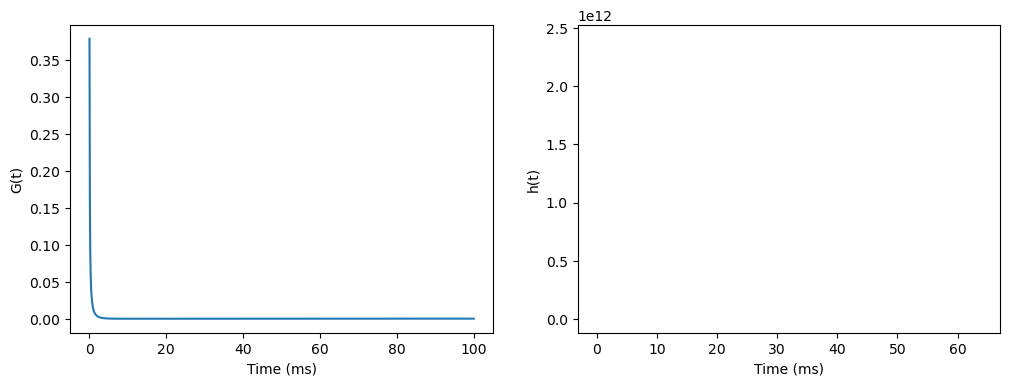

In [35]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

class TemporalParams:
    def __init__(self, nR, nD, tauR, tauD, ratio):
        self.nR = nR
        self.nD = nD
        self.tauR = tauR
        self.tauD = tauD
        self.ratio = ratio

def temporalKernel(tau, temp, lfac1, lfac2):
    tau1 = tau / temp.tauR
    tau2 = tau / temp.tauD
    A1 = (temp.nR-1) * np.log(tau1)
    A2 = (temp.nD-1) * np.log(tau2)
    tpR = np.exp(A1 - tau1 - lfac1) / temp.tauR
    tpD = np.exp(A2 - tau2 - lfac2) / temp.tauD
    tp = tpR - temp.ratio * tpD
    return tp

def integral(t_0, lfac1, lfac2, temp, nR, nD, tauR, tauD, ratio):
    def G(tau):
        tau1 = tau / temp.tauR
        tau2 = tau / temp.tauD
        A1 = (nR-1) * np.log(tau1)
        A2 = (nD-1) * np.log(tau2)
        tpR = np.exp(A1 - tau1 - lfac1) / temp.tauR
        tpD = np.exp(A2 - tau2 - lfac2) / temp.tauD
        tp = tpR - ratio * tpD
        return tp
    dt = 0.01  # 时间步长
    t = np.arange(0, t_0+dt, dt)
    g = G(t_0 - t)
    h = np.sum(g[:-1] + g[1:]) * dt / 2  # 梯形法求积分
    return h

def plot_G_and_h(t, lfac1, lfac2, temp):
    # 计算G(t)和h(t)
    Gt = temporalKernel(t, temp, lfac1, lfac2)
    ht = np.array([integral(ti, lfac1, lfac2, temp, temp.nR, temp.nD, temp.tauR, temp.tauD, temp.ratio) for ti in t])
    
    # 画图
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
    ax1.plot(t, Gt)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('G(t)')
    
    ax2.plot(t, ht)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('h(t)')
    
    plt.show()


tau = 0.1  # 时间常数
lfac1 = 0  # G(t)中的常量1
lfac2 =0  # G(t)中的常量2
nR = 6  # G(t)中的参数nR
nD = 6  # G(t)中的参数nD
tauR = 0.01  # G(t)中的参数tauR
tauD = 0.02  # G(t)中的参数tauD
ratio = 1  # G(t)中的参数ratio

temp = TemporalParams(tauR, tauD, nR, nD, ratio)
t = np.arange(0, 100, 0.1)  # 时间向量

plot_G_and_h(t, lfac1, lfac2, temp)



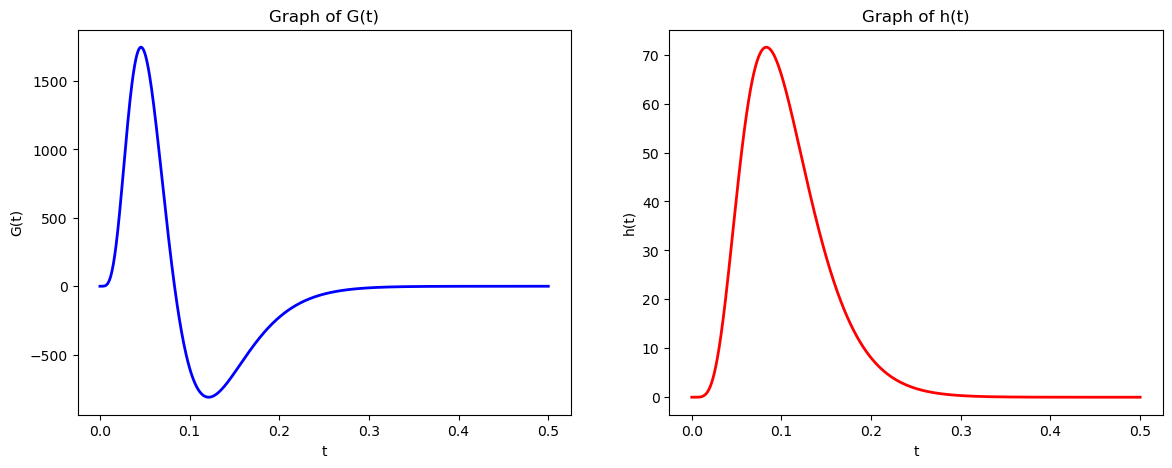

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps

# 定义 G(t) 函数
def G(t):
    tau0 = 0.01
    tau1 = 0.02
    return t**5/tau0**6 * np.exp(-t / tau0) - t**5/tau1**6 * np.exp(-t / tau1)

# 定义 h(t) 函数
def h(t):
    s = np.linspace(0, t, 1000)
    g = G(t - s)
    return simps(g, s)

# 生成数据点
t = np.linspace(0, 0.5, 1000)
y1 = G(t)
y2 = np.array([h(ti) for ti in t])

# 创建画布和子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 绘制 G(t) 图像
ax1.plot(t, y1, color='blue', linestyle='-', linewidth=2)
ax1.set_xlabel('t')
ax1.set_ylabel('G(t)')
ax1.set_title('Graph of G(t)')

# 绘制 h(t) 图像
ax2.plot(t, y2, color='red', linestyle='-', linewidth=2)
ax2.set_xlabel('t')
ax2.set_ylabel('h(t)')
ax2.set_title('Graph of h(t)')

# 显示图像
plt.show()
